# Intro Task, Object Localization 

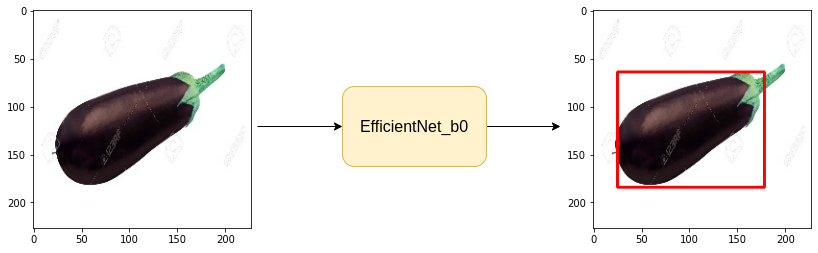

In [40]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-ovszx0yx
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-ovszx0yx
  Resolved https://github.com/albumentations-team/albumentations to commit 2a1826d49c9442ae28cf33ddef658c8e24505cf8
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [42]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [43]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [44]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'
EPOCHS = 40
LR = 0.001
IMAGE_SIZE = 140
BATCH_SIZE = 16
MODEL_NAME = 'efficientnet_b0'
NUM_COR = 4
WEIGHTS = 'imagenet'

In [45]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

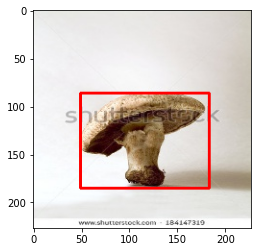

In [46]:
row = df.iloc[2]
image = cv2.imread(DATA_DIR + row.img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(image, pt1, pt2, (255,0,0),2)
plt.imshow(bnd_box_img)

In [47]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [48]:
import albumentations as A

In [49]:
train_augs = A.Compose([
       A.Resize(IMAGE_SIZE,IMAGE_SIZE), 
       A.HorizontalFlip(p=0.5),#50% change image will get flipped horizontally
       A.VerticalFlip(p=0.5),
       A.Rotate()
  ],bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))

valid_augs = A.Compose([
       A.Resize(IMAGE_SIZE,IMAGE_SIZE), 
      
  ],bbox_params=A.BboxParams(format='pascal_voc',label_fields=['class_labels']))



# Create Custom Dataset

In [50]:
class ObjLocDataset(torch.utils.data.Dataset):
   
    def __init__(self, df, augmentations) :
     self.df = df
     self.augmentations = augmentations
    
   
  
    def __len__(self):
      return len(self.df)

    def __getitem__(self, idx):

      row = self.df.iloc[idx]

      xmin = row.xmin
      ymin = row.ymin
      xmax = row.xmax
      ymax = row.ymax

      bbox = [[xmin,ymin,xmax,ymax]] # the list insdie list format is because albumentation takes bbox in this format

      img_path = DATA_DIR + row.img_path
      img = cv2.imread(img_path)
      img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      if self.augmentations:
        data = self.augmentations(image=img,bboxes = bbox, class_labels = [None] )
        img = data['image']
        bbox = data['bboxes'][0]

      img = torch.from_numpy(img).permute(2,0,1) / 255.0
      bbox = torch.Tensor(bbox)

      return img,bbox



In [51]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [52]:
print(f"Total example of Trainset : {len(trainset)}")
print(f"Total example of Validset : {len(validset)}")

Total example of Trainset : 148
Total example of Validset : 38


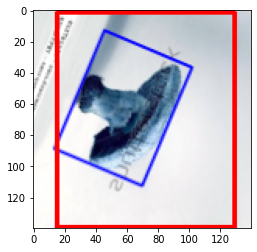

In [53]:
img, bbox = trainset[2]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [54]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True)
validloader = torch.utils.data.DataLoader(validset, batch_size= BATCH_SIZE)

In [55]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [56]:
for images,bboxes in trainloader:
  break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [57]:
from torch import nn 
import timm

In [58]:
class ObjLocModel(nn.Module):
   
   def __init__(self):
     super(ObjLocModel,self).__init__()

     self.backbone = timm.create_model(MODEL_NAME, pretrained=True,num_classes=4)

   def forward(self, images, gt_bboxes = None):

     bboxes = self.backbone(images)

     if gt_bboxes != None:
       loss = nn.MSELoss()(bboxes,gt_bboxes)
       return bboxes, loss

     return bboxes


In [59]:
model = ObjLocModel()
model.to(DEVICE); # for GPU 

In [60]:
# output shape
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [61]:
def train_fn(model, dataloader, optimizer):
   total_loss = 0.0
   model.train() # Dropout Layer ON

   for data in tqdm(dataloader):

     images , gt_bboxes = data
     images , gt_bboxes = images.to(DEVICE) , gt_bboxes.to(DEVICE)

     bboxes, loss = model(images, gt_bboxes)

     optimizer.zero_grad()
     loss.backward()
     optimizer.step()

     total_loss += loss.item()

   return total_loss / len(dataloader)

In [62]:
def eval_fn(model, dataloader):
   total_loss = 0.0
   model.eval() # Dropout Layer OFF
   
   with torch.no_grad():
    for data in tqdm(dataloader):

      images , gt_bboxes = data
      images , gt_bboxes = images.to(DEVICE) , gt_bboxes.to(DEVICE)

      bboxes, loss = model(images, gt_bboxes)
      total_loss += loss.item()

    return total_loss / len(dataloader)

#Training Loop

In [63]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)

In [32]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model,trainloader,optimizer)
  valid_loss = eval_fn(model,validloader)

  if valid_loss < best_valid_loss :
    torch.save(model.state_dict(),'best_model.pt')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} Train Loss : {train_loss} Valid_loss : {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

SAVED-MODEL
Epoch: 1 Train Loss : 2054.470104980469 Valid_loss : 333.9793701171875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

SAVED-MODEL
Epoch: 2 Train Loss : 1417.0289428710937 Valid_loss : 303.83607991536456


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3 Train Loss : 1123.7897094726563 Valid_loss : 594.0716552734375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

SAVED-MODEL
Epoch: 4 Train Loss : 822.7692993164062 Valid_loss : 267.76683044433594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

SAVED-MODEL
Epoch: 5 Train Loss : 674.6711456298829 Valid_loss : 242.77110799153647


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6 Train Loss : 501.0587097167969 Valid_loss : 588.7549031575521


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 7 Train Loss : 461.7942260742187 Valid_loss : 1052.8768107096355


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8 Train Loss : 420.9890991210938 Valid_loss : 1258.7266438802083


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 Train Loss : 381.87311096191405 Valid_loss : 295.0474853515625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10 Train Loss : 303.019189453125 Valid_loss : 248.23982747395834


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11 Train Loss : 307.45871887207034 Valid_loss : 272.7531992594401


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12 Train Loss : 309.3594482421875 Valid_loss : 284.22533162434894


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13 Train Loss : 248.54918670654297 Valid_loss : 271.59156799316406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14 Train Loss : 251.52654571533202 Valid_loss : 293.6855773925781


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15 Train Loss : 279.3675933837891 Valid_loss : 302.8460388183594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 Train Loss : 224.0399932861328 Valid_loss : 257.1041514078776


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17 Train Loss : 260.0242614746094 Valid_loss : 256.2993876139323


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18 Train Loss : 271.813720703125 Valid_loss : 472.313720703125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19 Train Loss : 242.36946563720704 Valid_loss : 259.241948445638


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20 Train Loss : 251.86936950683594 Valid_loss : 274.0316874186198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21 Train Loss : 238.00325469970704 Valid_loss : 246.63358561197916


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22 Train Loss : 265.37490997314455 Valid_loss : 247.9851277669271


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23 Train Loss : 225.6273223876953 Valid_loss : 279.6193084716797


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 Train Loss : 231.43116912841796 Valid_loss : 271.2368570963542


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25 Train Loss : 222.65540466308593 Valid_loss : 244.52229817708334


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26 Train Loss : 212.46829223632812 Valid_loss : 248.63992309570312


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 Train Loss : 248.4755661010742 Valid_loss : 244.16847229003906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

SAVED-MODEL
Epoch: 28 Train Loss : 226.42490921020507 Valid_loss : 240.31501261393228


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29 Train Loss : 227.64843292236327 Valid_loss : 248.02442932128906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 Train Loss : 208.92125396728517 Valid_loss : 320.24415079752606


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 Train Loss : 237.415087890625 Valid_loss : 273.90956624348956


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32 Train Loss : 218.0884002685547 Valid_loss : 246.91203816731772


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

SAVED-MODEL
Epoch: 33 Train Loss : 214.29571380615235 Valid_loss : 232.18509928385416


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 Train Loss : 230.43627471923827 Valid_loss : 241.60856119791666


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 Train Loss : 214.52220306396484 Valid_loss : 253.01416524251303


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 Train Loss : 215.00538940429686 Valid_loss : 239.73542277018228


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 Train Loss : 219.66685333251954 Valid_loss : 247.57565307617188


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38 Train Loss : 198.21141815185547 Valid_loss : 280.32130940755206


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 Train Loss : 227.2593505859375 Valid_loss : 240.71563212076822


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40 Train Loss : 218.80345001220704 Valid_loss : 241.19989522298178


#Inference

In [64]:
import utils

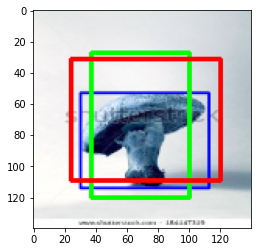

In [65]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():

  image, gt_bbox = validset[34] # (c,h,w)
  image = image.unsqueeze(0).to(DEVICE) # (bs,c,h,w)
  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya